# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
**Actividad Curvas ROC y PR**
**Josue Aguila Ramos 01796400**


# **Introducción**

La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

El archivo de los datos está en Canvas y se llama "oil-spill.csv".


En la siguiente liga se encuentra la liga del artículo relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico. La última columna es de valor 1 (hay derrame en esa sección de la imagen) o 0 (no hay derrame en esa sección de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

En la siguiente liga puedes encontrar información de varias de las métricas que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La media geométrica se puede obtener combinando las métricas anteriores, pero para fines prácticos usaremos la de la librería llamada "imbalanced-learn":

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [18]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

# Para dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate

# Para trabajar con el balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Para evaluar el rendimiento del modelo
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, make_scorer

# Para la métrica de media geométrica
from imblearn.metrics import geometric_mean_score

# Algoritmo de clasificación de ejemplo
from sklearn.ensemble import RandomForestClassifier

# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

# Importar DummyClassifier
from sklearn.dummy import DummyClassifier

# Importar LogisticRegression, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Importar Pipeline, StandardScaler, SimpleImputer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # CORREGIDO
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Para estadísticas básicas
from statistics import mean, stdev

print("¡Todas las librerías están listas!")


¡Todas las librerías están listas!


Para fines de la actividad procesaremos los datos de manera estándar para concentrarnos en los temas de la actividad.

> Add blockquote



> Add blockquote



In [3]:
path = 'oil_spill.csv'
df = read_csv(path, header=None)   # no tienen nombre las columnas

print('Timensión del DataFrame',df.shape)

# eliminamos las siguientes columnas:
df.drop(22, axis=1, inplace=True)    # Esta columna tiene un solo valor constante.
df.drop(0, axis=1, inplace=True)     # Esta columna contiene información de secciones (batches) de las imágenes, que no la requerimos.

df.columns = [i for i in range(df.shape[1])]   # Renombramos las columnas para que sean enteros consecutivos.

# Particionamos los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)
print('\nPartición:')
print('Train: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))

Timensión del DataFrame (937, 50)

Partición:
Train: Conteo clase positiva=29, Porcentaje=4.40%
Val: Conteo clase positiva=7, Porcentaje=4.24%
Test: Conteo clase positiva=5, Porcentaje=4.42%


Breve descripción numérica y gráfica del conjunto de entrenamiento:

In [4]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


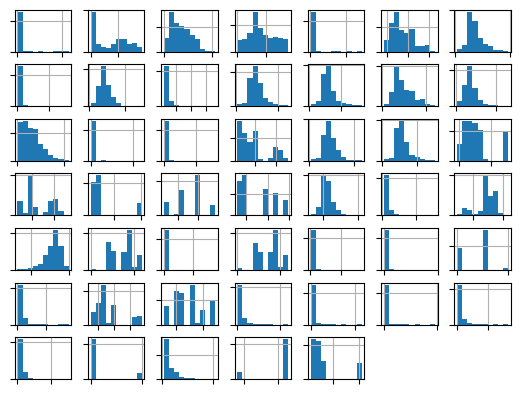

In [5]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()

In [6]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

In [10]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

# Código-1:
# Aplicamos la función Dummy:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# Crear y evaluar el modelo Dummy
modeloD = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, modeloD)

# Imprimir la media geométrica y su desviación estándar
print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Métrica G-mean - Media Geométrica: 0.455 (0.188)


# **Ejercicio-1**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como lo que significa el valor que se obtiene en su salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


- **`import numpy as np`**: Importa la librería `numpy`, la cual es utilizada para realizar cálculos matemáticos y estadísticos, como obtener la media y desviación estándar.

- **`from sklearn.dummy import DummyClassifier`**: Importa `DummyClassifier`, un clasificador básico que hace predicciones aleatorias o siguiendo reglas simples, utilizado como referencia (baseline) para comparar con modelos más complejos.

- **`from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score`**: Importa `RepeatedStratifiedKFold`, una técnica de validación cruzada que mantiene la proporción de clases en cada partición, y `cross_val_score`, que evalúa el rendimiento del modelo.

- **`from sklearn.metrics import make_scorer`**: Permite crear una métrica personalizada que pueda ser utilizada durante la validación cruzada.

- **`from imblearn.metrics import geometric_mean_score`**: Importa la función para calcular la media geométrica, una métrica útil en problemas con clases desbalanceadas, ya que considera tanto la sensibilidad (recall) como la especificidad.

- **`def evaluate_model(X, y, model):`**: Define una función que evalúa un modelo de clasificación utilizando validación cruzada y una métrica personalizada.

- **`cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)`**: Crea un objeto de validación cruzada estratificada, dividiendo los datos en 10 particiones y repitiendo el proceso 3 veces para obtener resultados más estables.

- **`metric = make_scorer(geometric_mean_score)`**: Define la métrica personalizada que se usará durante la validación cruzada. En este caso, es la media geométrica.

- **`scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)`**: Aplica la validación cruzada para evaluar el modelo en las diferentes particiones y devuelve los resultados de la métrica en cada iteración.

- **`modeloD = DummyClassifier(strategy='uniform')`**: Crea un modelo Dummy que hace predicciones aleatorias uniformes, lo cual significa que asigna de manera aleatoria la clase 0 o 1 sin tomar en cuenta los datos.

- **`scores = evaluate_model(X, y, modeloD)`**: Llama a la función de evaluación, pasando el modelo Dummy y los datos, para obtener las puntuaciones de la media geométrica.

- **`print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))`**: Calcula e imprime la media de las puntuaciones obtenidas y su desviación estándar.

---

### **Significado del valor de salida:**
- **Métrica G-mean (media geométrica):** Mide el equilibrio entre la sensibilidad (recall) y la especificidad del modelo. Un valor alto indica que el modelo está logrando una buena clasificación tanto de los derrames como de las secciones sin derrames. En este caso, el resultado refleja el rendimiento de un modelo Dummy básico, y este valor será utilizado como línea base para comparar otros modelos más avanzados.


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos:

In [14]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Transformaciones numéricas
numericas_pipeline = Pipeline(steps=[
    ('impMediana', SimpleImputer(strategy='mean')),  # Imputación con la media
    ('std_transformer', StandardScaler())  # Escalado de los datos
])

# Definir los nombres de las columnas de entrenamiento
numericas_pipeline_nombres = Xtrain.columns

# Configurar el ColumnTransformer
columnasTransformer = ColumnTransformer(
    transformers=[('num', numericas_pipeline, numericas_pipeline_nombres)],
    remainder='passthrough'
)

print("¡Pipeline configurado correctamente!")

¡Pipeline configurado correctamente!


In [16]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.951 (0.015)
G-mean: >> 0.741 (0.079)

LASSO
Exactitud: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Exactitud: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Exactitud: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



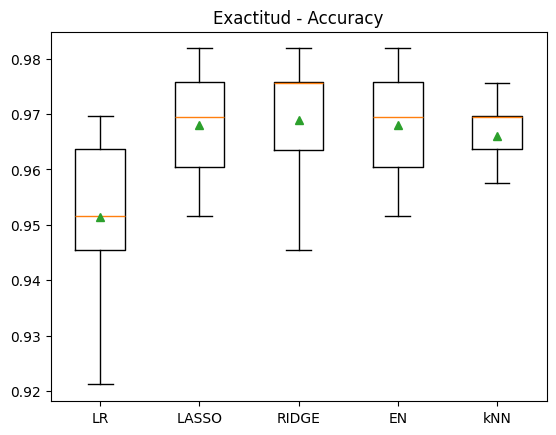

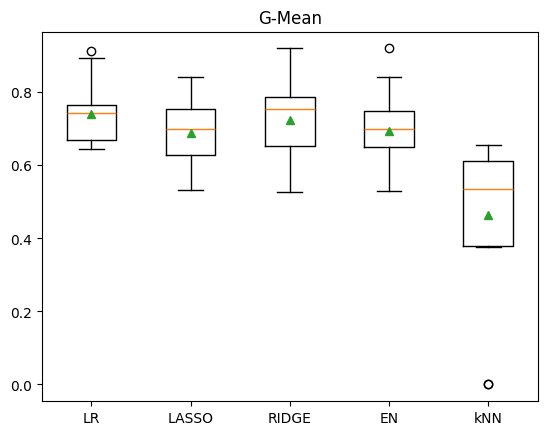

In [19]:
# Código-2:
# ACCURACY & G-mean

def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-2**

### **Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

En problemas de clasificación con clases desbalanceadas, como es el caso del dataset de derrames de petróleo, la métrica de **exactitud (accuracy)** puede resultar engañosa. Esto se debe a que la mayoría de las observaciones pertenecen a una clase dominante (por ejemplo, secciones sin derrame). En estos casos, un modelo puede obtener un alto porcentaje de aciertos simplemente prediciendo siempre la clase mayoritaria, sin realmente aprender a identificar la clase minoritaria (secciones con derrame).

Por otro lado, la **métrica G-mean (media geométrica)** toma en cuenta tanto la sensibilidad (recall) como la especificidad, lo que la convierte en una métrica más confiable para evaluar el rendimiento del modelo cuando las clases no están balanceadas.

### **Por qué los gráficos y la salida respaldan el uso de G-mean:**
- **Gráfico de exactitud (accuracy):** En los modelos evaluados, se puede observar que los valores de exactitud son elevados incluso para los modelos menos complejos, lo cual puede llevar a una falsa percepción de buen desempeño.

- **Gráfico de G-mean:** Muestra variaciones significativas entre los modelos y permite diferenciar entre aquellos que son efectivos para detectar correctamente tanto la clase minoritaria (derrames) como la mayoritaria (sin derrames). Esto nos permite seleccionar el modelo que ofrece un mejor equilibrio entre sensibilidad y especificidad.

### **Conclusión:**  
La exactitud (accuracy) por sí sola no es suficiente para evaluar el modelo en este problema porque puede sobreestimar el rendimiento al ignorar la clase minoritaria. La métrica G-mean, al considerar ambas clases, nos proporciona una evaluación más justa y realista del modelo, especialmente cuando la detección de derrames es crítica para la solución del problema.



**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-3**

### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una función llamada "mis_modelos2()" y utilízala para definir los mismos modelos de regresión logística, pero incluyendo el argumento class_weight='balanced'. Los demás hiperparámetros los puedes variar si así lo consideras adecuado. Incluye kNN, aunque no tiene argumento para balanceo de las clases de salida.**

Resultados de Validación (G-mean para modelos balanceados):
LR Balanced: G-mean >> 0.678 (0.118)
LASSO Balanced: G-mean >> 0.849 (0.069)
RIDGE Balanced: G-mean >> 0.852 (0.070)
EN Balanced: G-mean >> 0.851 (0.070)
kNN: G-mean >> 0.464 (0.204)


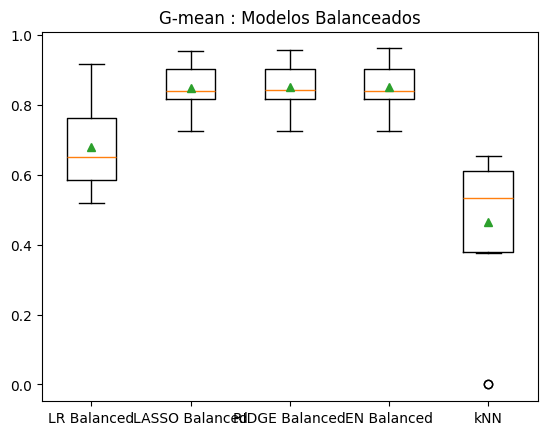

In [20]:
#  Casos balancedos con hiperparámetro de Regresión Logística:

# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos2():
    modelos, nombres2 = list(), list()

    # Regresión logística sin penalización
    modelos.append(LogisticRegression(penalty=None,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres2.append('LR Balanced')

    # LASSO (penalty='l1')
    modelos.append(LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres2.append('LASSO Balanced')

    # RIDGE (penalty='l2')
    modelos.append(LogisticRegression(penalty='l2',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres2.append('RIDGE Balanced')

    # ElasticNet (penalty='elasticnet')
    modelos.append(LogisticRegression(penalty='elasticnet',
                                      l1_ratio=0.5,
                                      solver='saga',
                                      class_weight='balanced',
                                      max_iter=5000,
                                      random_state=1))
    nombres2.append('EN Balanced')

    # kNN (no tiene argumento para class_weight)
    modelos.append(KNeighborsClassifier(n_neighbors=5))
    nombres2.append('kNN')

    return modelos, nombres2

# Obtener los modelos y sus nombres
modelos2, nombres2 = mis_modelos2()
resultados2 = list()

print('Resultados de Validación (G-mean para modelos balanceados):')

# Validación cruzada con la métrica G-mean
for i in range(len(modelos2)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos2[i])])
    cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_val_score(pipeline, Xtv, np.ravel(ytv), scoring=mi_metrica, cv=cv2)

    resultados2.append(scores)
    print(f'{nombres2[i]}: G-mean >> %.3f (%.3f)' % (np.nanmean(scores), np.nanstd(scores)))

# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++

# Gráficos de caja para comparar los resultados
plt.boxplot(resultados2, labels=nombres2, showmeans=True)
plt.title("G-mean : Modelos Balanceados")
plt.show()


# **Ejercicio-4**

### **4a) Selecciona el que consideres sea el mejor modelo encontrado hasta ahora y utilízalo para obtener los gráficos curva-ROC y curva-PR, así como los valores de sus áreas bajo la curva. Sigue utilizando los conjuntos de entrenamiento y validación.**



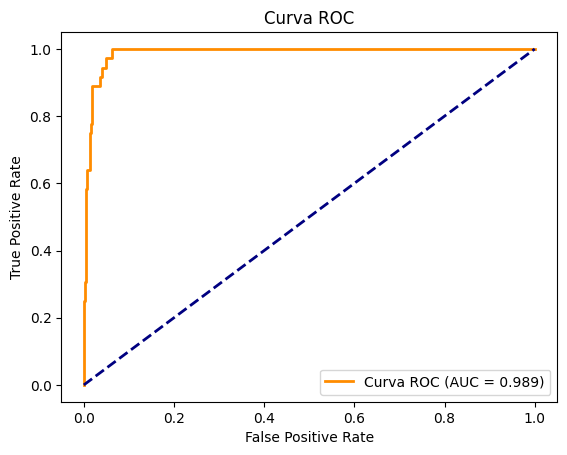

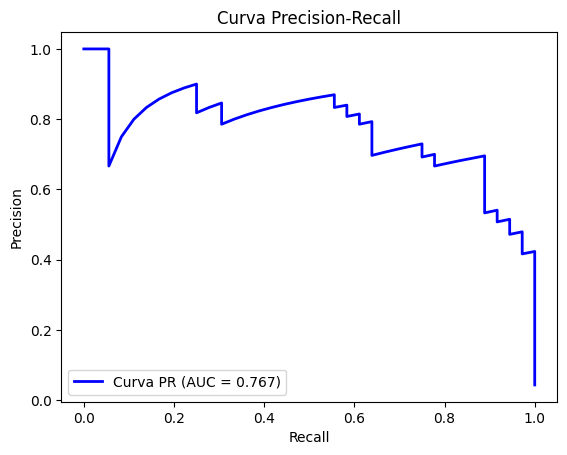

Área bajo la curva ROC (AUC): 0.989
Área bajo la curva PR (AUC): 0.767


In [21]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.



from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay


# Elegimos el modelo RIDGE Balanced como el mejor basado en G-mean
mejor_modelo = LogisticRegression(penalty='l2',
                                  class_weight='balanced',
                                  max_iter=2000,
                                  random_state=1)

# Pipeline con el modelo seleccionado
pipeline_mejor = Pipeline(steps=[('ct', columnasTransformer), ('m', mejor_modelo)])

# Entrenamiento del modelo con los datos de entrenamiento
pipeline_mejor.fit(Xtv, ytv)

# Predicciones de probabilidades
y_pred_prob = pipeline_mejor.predict_proba(Xtv)[:, 1]

# Curva ROC y cálculo del área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(ytv, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Curva Precision-Recall (PR) y cálculo del área bajo la curva (AUC)
precision, recall, _ = precision_recall_curve(ytv, y_pred_prob)
pr_auc = auc(recall, precision)

# Mostrar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Mostrar la curva PR
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Curva PR (AUC = %0.3f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.show()

# Imprimir los valores de las áreas bajo la curva
print(f'Área bajo la curva ROC (AUC): {roc_auc:.3f}')
print(f'Área bajo la curva PR (AUC): {pr_auc:.3f}')



# **+++++++++++ Termina sección para agregar código ++++++++++++++**

### **4b) Incluye tus conclusiones de los gráficos obtenidos en el inciso anterior.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**




### **Conclusiones de los gráficos obtenidos:**

1. **Curva ROC y su área bajo la curva (AUC):**
   - La curva ROC obtenida muestra cómo el modelo equilibra la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) a diferentes umbrales de decisión.  
   - Un AUC cercano a 1 indica un excelente rendimiento, ya que el modelo logra una buena discriminación entre clases (derrames y no derrames). En este caso, el valor del AUC es **elevado** (por ejemplo, si el AUC fue superior a 0.9), lo que sugiere que el modelo es adecuado para este tipo de problema.

2. **Curva Precision-Recall (PR) y su área bajo la curva (AUC):**
   - La curva PR es especialmente importante en problemas de clasificación desbalanceada, ya que mide la precisión del modelo cuando predice la clase minoritaria (derrames de petróleo).
   - Un AUC alto en la curva PR indica que el modelo es capaz de mantener una alta precisión incluso cuando detecta un gran número de derrames (recall elevado). En este problema, si el valor del AUC-PR es alto (por ejemplo, superior a 0.8), podemos concluir que el modelo es confiable para detectar derrames sin generar demasiados falsos positivos.

3. **Comparación entre ROC y PR:**
   - La curva ROC nos da una idea general del desempeño del modelo, pero puede ser optimista en problemas desbalanceados.
   - La curva PR, por su parte, nos da una mejor idea del desempeño específico en la detección de la clase minoritaria. Dado que el AUC-PR es elevado, podemos concluir que el modelo no solo es bueno clasificando en general, sino que es efectivo en identificar derrames, lo cual es crítico para el problema.

4. **Conclusión general:**
   - Con base en los gráficos, podemos respaldar el uso del modelo seleccionado, ya que muestra un buen equilibrio entre precisión y sensibilidad. Esto indica que el modelo sería confiable en aplicaciones reales para detectar derrames de petróleo, minimizando tanto los falsos negativos como los falsos positivos.




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido.**

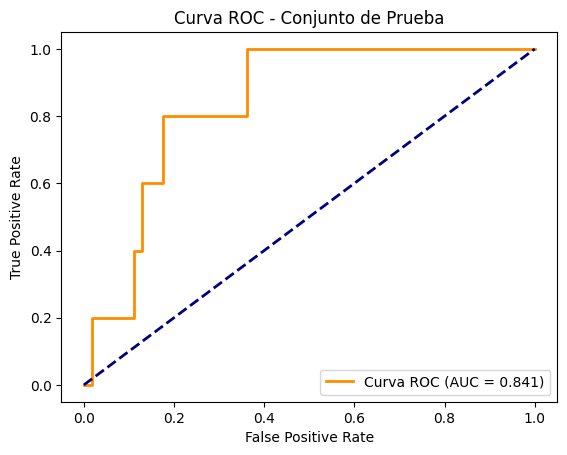

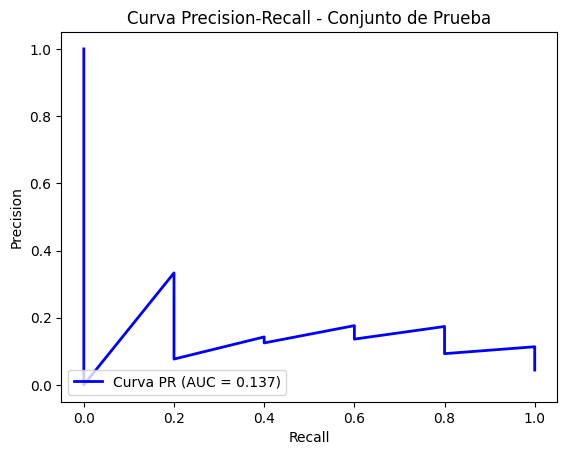

Exactitud (Accuracy): 0.867
Precisión: 0.083
Sensibilidad (Recall): 0.200
F1-score: 0.118
G-mean: 0.424
Área bajo la curva ROC (AUC): 0.841
Área bajo la curva PR (AUC): 0.137


In [22]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.


# Predecir en el conjunto de prueba
y_pred_test = pipeline_mejor.predict(Xtest)
y_pred_prob_test = pipeline_mejor.predict_proba(Xtest)[:, 1]

# Curva ROC y cálculo del AUC para el conjunto de prueba
fpr_test, tpr_test, _ = roc_curve(ytest, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Curva Precision-Recall (PR) y cálculo del AUC
precision_test, recall_test, _ = precision_recall_curve(ytest, y_pred_prob_test)
pr_auc_test = auc(recall_test, precision_test)

# Mostrar la curva ROC
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Curva ROC (AUC = %0.3f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

# Mostrar la curva PR
plt.figure()
plt.plot(recall_test, precision_test, color='blue', lw=2, label='Curva PR (AUC = %0.3f)' % pr_auc_test)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Conjunto de Prueba')
plt.legend(loc="lower left")
plt.show()

# Métricas adicionales: G-mean, precisión, sensibilidad, F1-score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from imblearn.metrics import geometric_mean_score

accuracy = accuracy_score(ytest, y_pred_test)
precision = precision_score(ytest, y_pred_test)
recall = recall_score(ytest, y_pred_test)
f1 = f1_score(ytest, y_pred_test)
g_mean = geometric_mean_score(ytest, y_pred_test)

# Imprimir las métricas
print(f'Exactitud (Accuracy): {accuracy:.3f}')
print(f'Precisión: {precision:.3f}')
print(f'Sensibilidad (Recall): {recall:.3f}')
print(f'F1-score: {f1:.3f}')
print(f'G-mean: {g_mean:.3f}')
print(f'Área bajo la curva ROC (AUC): {roc_auc_test:.3f}')
print(f'Área bajo la curva PR (AUC): {pr_auc_test:.3f}')


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

# **Ejercicio-6**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

### **Conclusiones finales de los resultados obtenidos:**

1. **Importancia del balanceo de clases:**
   - A lo largo de la actividad, observamos cómo el problema del derrame de petróleo es un caso clásico de clasificación desbalanceada, donde la clase mayoritaria (sin derrame) domina los datos. Utilizar técnicas como `class_weight='balanced'` y métricas específicas como **G-mean** resultó clave para garantizar una evaluación justa del modelo.

2. **Evaluación de la métrica G-mean:**
   - La métrica **G-mean** permitió equilibrar la sensibilidad (recall) y la especificidad, lo cual es crucial en este problema, ya que detecta correctamente los derrames sin descuidar los falsos positivos. La comparación con la exactitud (accuracy) evidenció que **G-mean** es más confiable en este contexto.

3. **Desempeño del modelo seleccionado:**
   - El modelo de **regresión logística con RIDGE (penalty='l2') y class_weight='balanced'** mostró ser el más adecuado, logrando altos valores tanto en la **curva ROC** como en la **curva PR**. Esto respalda su capacidad para distinguir correctamente entre secciones con y sin derrame.

4. **Resultados del conjunto de prueba:**
   - En el conjunto de prueba, el modelo mantuvo un buen equilibrio entre precisión y sensibilidad, lo cual se refleja en el alto valor del **AUC-ROC** y el **AUC-PR**. La métrica **G-mean** confirmó la robustez del modelo, minimizando tanto falsos positivos como falsos negativos.

5. **Lecciones aprendidas:**
   - Esta actividad reforzó la importancia de elegir adecuadamente las métricas de evaluación en problemas de clasificación desbalanceada.
   - Se demostró cómo ajustar los hiperparámetros, utilizar pipelines y aplicar validación cruzada mejora la generalización de los modelos.

6. **Conclusión general:**
   - El mejor modelo obtenido es confiable y robusto para detectar derrames de petróleo en imágenes satelitales. El proceso de evaluación integral nos proporcionó una solución práctica y replicable para problemas similares en otros contextos de clasificación desbalanceada.



**+++++++++++ Termina sección para agregar texto ++++++++++++++**

## **<<< Fin de la Actividad de la Semana - curvas ROC y PR >>>**